# Исследование временных рядов

## Основная часть

### 1. Чтение файла

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv('stat4.csv', sep=';')
df.head()

,Year,Employees
0,2001,289000
1,2002,258000
2,2003,241000
3,2004,224000
4,2005,215000


### 2. Наглядное представление данных

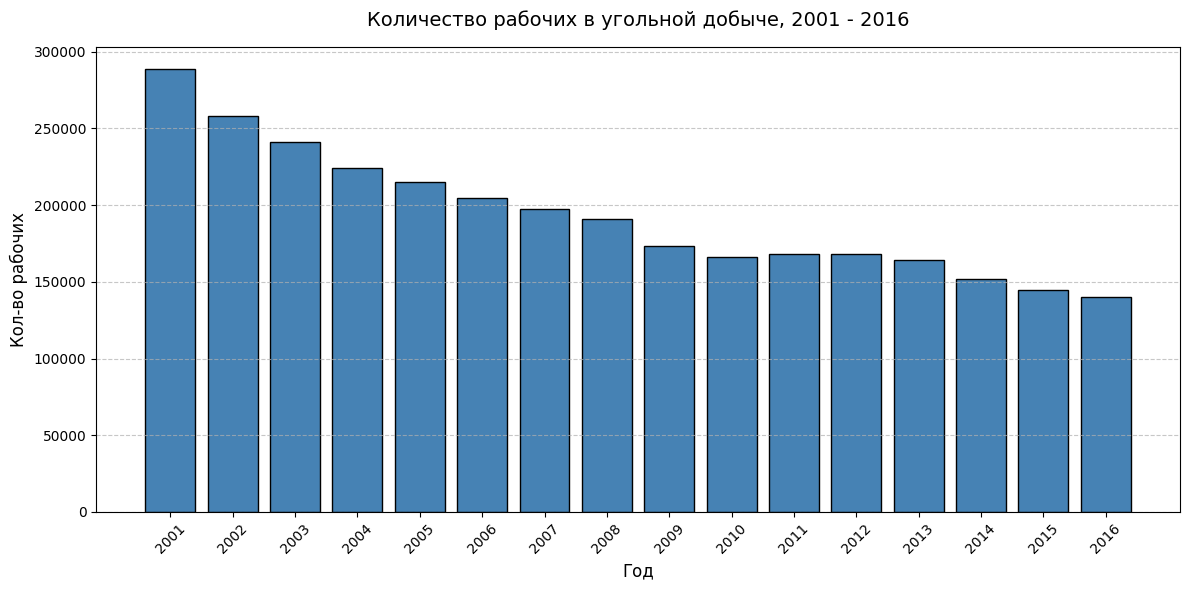

In [3]:
years = df['Year']
values = df['Employees']

plt.figure(figsize=(12, 6))
plt.bar(years, values, color='steelblue', edgecolor='black')

plt.title('Количество рабочих в угольной добыче, 2001 - 2016', fontsize=14, pad=15)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Кол-во рабочих', fontsize=12)
plt.xticks(years, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

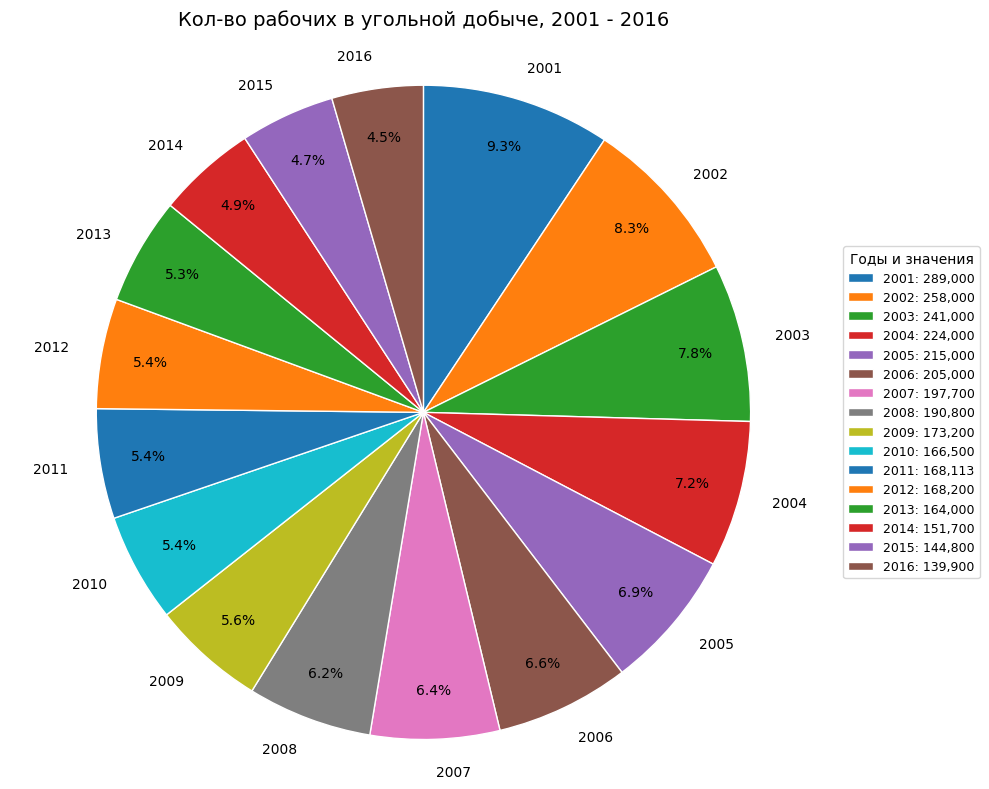

In [4]:
plt.figure(figsize=(10, 8))

wedges, texts, autotexts = plt.pie(values, 
labels=years, 
autopct='%1.1f%%',
startangle=90, 
counterclock=False,
pctdistance=0.85,
wedgeprops={'edgecolor': 'white', 'linewidth': 1})

plt.title('Кол-во рабочих в угольной добыче, 2001 - 2016', 
          fontsize=14, pad=20)

plt.legend(wedges, [f'{year}: {value:,}' for year, value in zip(years, values)],
           title="Годы и значения",
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1),
           fontsize=9)

plt.axis('equal')
plt.tight_layout()
plt.show()

### 3. Проверка ряда на стационарность

ADF Statistic: -4.057350487828628
p-value: 0.0011382561589230154


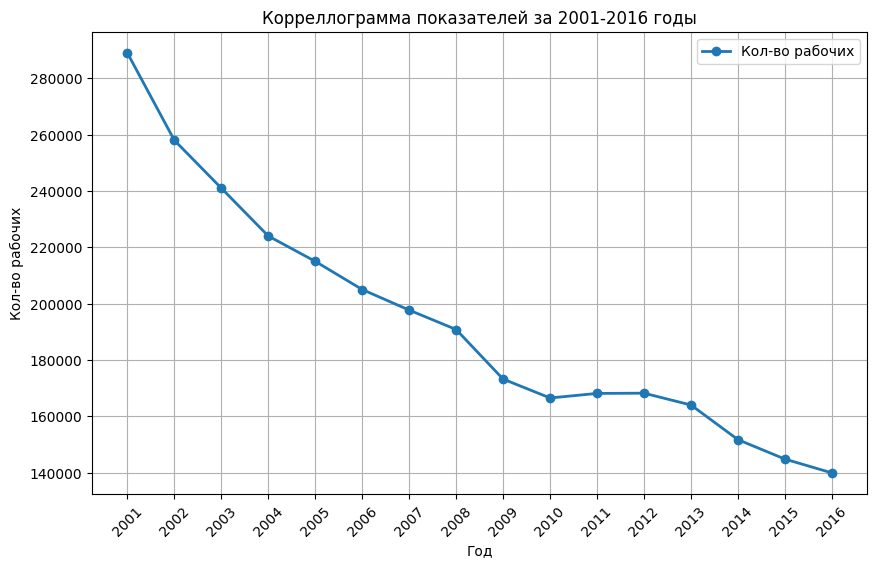

In [5]:
from statsmodels.tsa.stattools import adfuller

plt.figure(figsize=(10, 6))
plt.plot(years, values, marker='o', label="Кол-во рабочих", linewidth=2)
plt.xticks(years, rotation=45)
plt.title('Корреллограмма показателей за 2001-2016 годы')
plt.xlabel('Год')
plt.ylabel('Кол-во рабочих')
plt.grid()
plt.legend()

result = adfuller(values)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

<Figure size 1200x600 with 0 Axes>

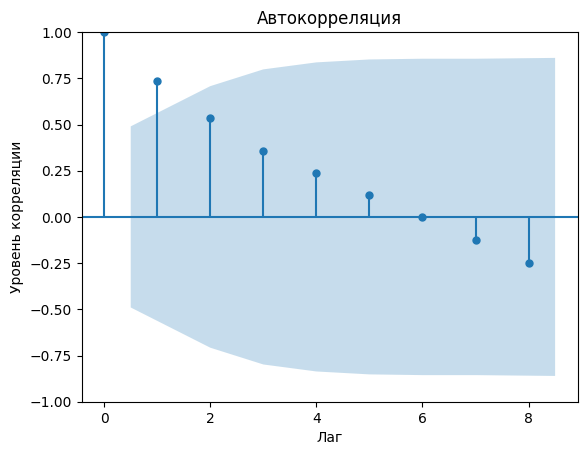

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12, 6))
plot_acf(values)
plt.title('Автокорреляция')
plt.xlabel('Лаг')
plt.ylabel('Уровень корреляции')
plt.show()

### 4. Определение аномальных уровней

In [7]:
diffs = np.abs(np.diff(values))
sigma = np.std(values, ddof=1)
lambda_vals = diffs / sigma
outliers_idx = np.where(lambda_vals > 1.3)[0] + 1
outliers_lambda = lambda_vals[outliers_idx - 1]

print(f"Lambda(t)\n{lambda_vals}\n")
print(f"Anomaly\n{outliers_idx}")

Lambda(t)
[0.72566575 0.39794573 0.39794573 0.21067715 0.23408572 0.17088258
 0.16151915 0.41199088 0.15683744 0.03775803 0.00203655 0.098316
 0.28792544 0.16151915 0.11470201]

Anomaly
[]


### 5. Определение наличия тренда

In [8]:
def fs_test(data):
    data = np.asarray(data)
    n = len(data)
    
    q_i, p_i = np.zeros(n, dtype=int), np.zeros(n, dtype=int)

    for i in range(2, n):
        if data[i] > np.max(data[:i]):
            q_i[i] = 1
        if data[i] < np.min(data[:i]):
            p_i[i] = 1

    d_i = q_i - p_i
    S = np.sum(d_i)
    temp = 2 * sum([1/i for i in range(2, n)])
        
    return S / temp

result = fs_test(values)
print(f"t_в = {result:.4f}")

t_в = -2.5882


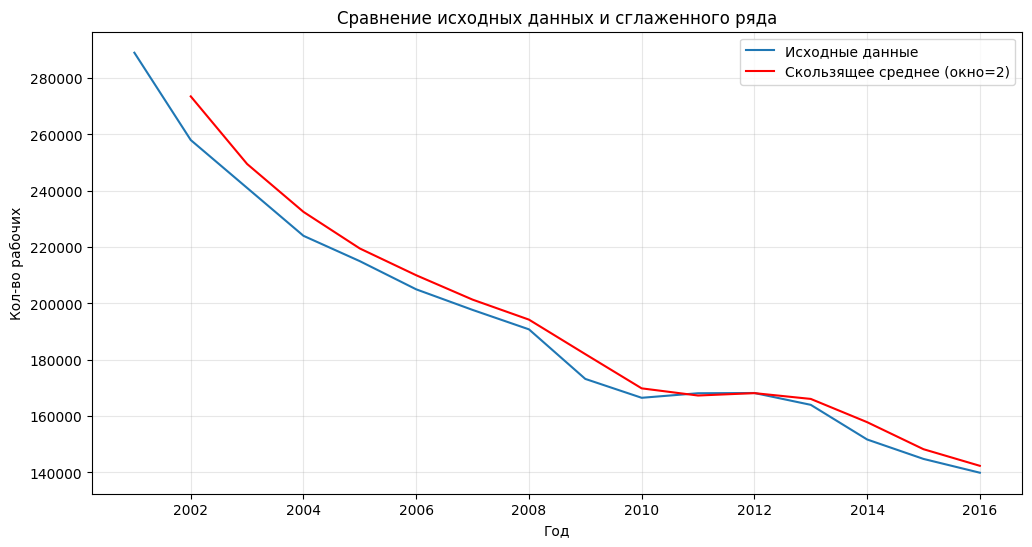

In [9]:
win_size = 2
df['NoTrend'] = values.rolling(window=win_size).mean()
plt.figure(figsize=(12, 6))
plt.plot(years, values, label='Исходные данные')
plt.plot(years, df['NoTrend'], label=f'Скользящее среднее (окно={win_size})', color='red')
plt.title('Сравнение исходных данных и сглаженного ряда')
plt.xlabel('Год')
plt.ylabel('Кол-во рабочих')
plt.legend()
plt.grid(True, alpha=0.3)

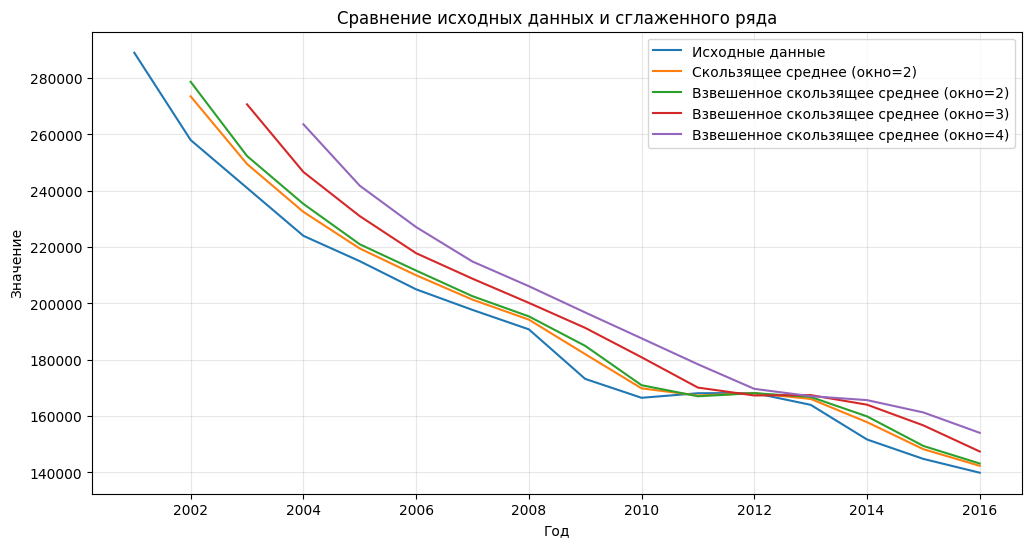

In [10]:
def wma(series, window):
    values = np.array(series)
    n_ = len(values)
    weights = np.arange(window, 0, -1)
    weights_norm = weights / weights.sum()
    wma_values = np.full(n_, np.nan)

    for t in range(window - 1, n_):
        window_values = values[t - window + 1 : t + 1]
        wma_values[t] = np.sum(window_values * weights_norm)
    
    return wma_values

plt.figure(figsize=(12, 6))
plt.plot(years, values, label='Исходные данные')
plt.plot(years, df['NoTrend'], label=f'Скользящее среднее (окно={win_size})')
plt.plot(years, wma(values, 2), label=f"Взвешенное скользящее среднее (окно=2)")
plt.plot(years, wma(values, 3), label=f"Взвешенное скользящее среднее (окно=3)")
plt.plot(years, wma(values, 4), label=f"Взвешенное скользящее среднее (окно=4)")
plt.title('Сравнение исходных данных и сглаженного ряда')
plt.xlabel('Год')
plt.ylabel('Значение')
plt.grid(alpha=0.3)
plt.legend()

### 6. Вычисление параметров модели

In [11]:
x = years.values - years.values[0]
y = values.values
y_log = np.log(y)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y_log)
b = slope 
a = np.exp(intercept)

print(f"Модель: y = {a:.2f} * ({b:.2f}) ^ t")

Модель: y = 262603.04 * (-0.04) ^ t


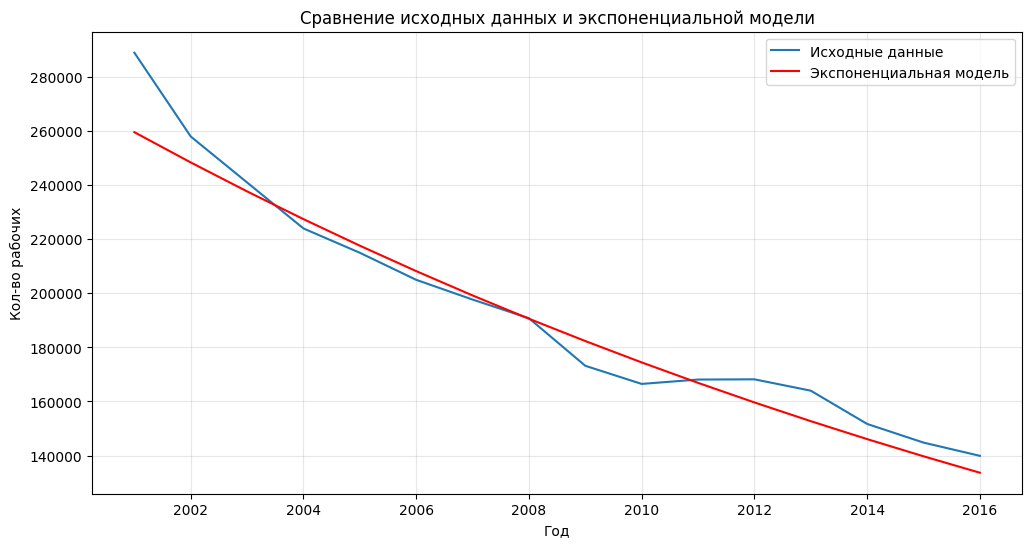

In [12]:
k = -3_000

y_pred = a * np.exp(b * x) + k
plt.figure(figsize=(12, 6))
plt.plot(years, values, label='Исходные данные')
plt.plot(years, y_pred, 'r-', label='Экспоненциальная модель')
plt.title('Сравнение исходных данных и экспоненциальной модели')
plt.xlabel('Год')
plt.ylabel('Кол-во рабочих')
plt.legend()
plt.grid(alpha=0.3)

## Дополнительная часть

### 7. Оценка остаточной компоненты

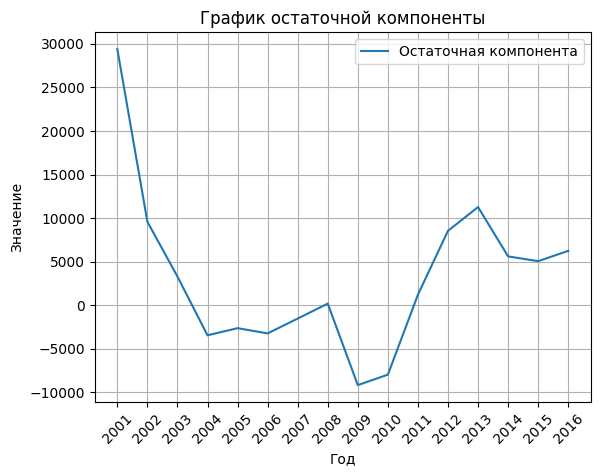

In [19]:
residuals = y - y_pred
plt.plot(years, residuals, label='Остаточная компонента')
plt.title('График остаточной компоненты')
plt.xlabel('Год')
plt.ylabel('Значение')
plt.legend()
plt.xticks(years, rotation=45)
plt.grid()

### 8. Использование дополнительных критериев

In [14]:
R = (max(values) - min(values))
S = np.std(values, ddof=1)
Z = R/S
print(f"Z_RS = {Z}")

Z_RS = 3.490218156858575


In [15]:
e = np.array(residuals)
mean_e = np.mean(e)
se = np.std(e, ddof=1) / np.sqrt(len(e))
t_mat = mean_e / se
print(f"t_mat = {t_mat}")

t_mat = 1.4262912026143995


In [18]:
n_ = 8
years1 = values[:n_]
years2 = values[n_:]

y1 = np.mean(years1)
y2 = np.mean(years2)

s = np.sqrt(1 / n_ + 1 / n_)
sigma = np.std(values)

t = abs(y1 - y2) / (sigma * s)
print(f"t = {t}")

t = 3.288498513097968
